<center><img src="img/logo_hse.png" width="1000"></center>

<h1><center>Прикладные задачи анализа данных</center></h1>
<h2><center>Домашнее задание 1: Генеративные сети</center></h2>

# Введение

Не все же нам MNIST генерировать. Давайте посмотрим, как генеративные модели могут использоваться не только для развлечения. Поехали!

Немного вступления и мотивации, для чего мы хотим обучать модель.

## MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ).

MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

#### Ок, давайте зафиксируем. Какой-то крутой телескоп позволяет открыть новые виды излучения. Идем дальше.

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение.
#### По фотографиям можно определить тип частицы из космоса: фотон или протон. Знакомая формулировка задачи, не правда ли?

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Ниже пример такой фотографии.

<center><img src="img/geo.jpg" width="400"></center>

#### Итак, каждая фотография описывается набором параметров, которые за нас считает телесоп. А что там с двумя видами частиц?

## Фотоны vs адронов

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Получение каждого такого изображения - дорогое удовольствие!


<center><img src="img/gamma_p.png" width="600"></center>

Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.

#### Итак, давайте сэкономим денег для ученых и сгенерируем хороших фотографий разных частиц. Используем для этого GAN и диффузионные модели!

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Данные

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [ ]:
# read data
names = np.array(
    [
        "Length",
        "Width",
        "Size",
        "Conc",
        "Conc1",
        "Asym",
        "M3Long",
        "M3Trans",
        "Alpha",
        "Dist",
        "class",
    ]
)
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
print(data.shape)
data.head()

(19020, 11)


,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


# Постановка задачи

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научиться генерировать параметры кластеров на изображениях телескопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [ ]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == "h"] = 0

In [ ]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [ ]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

In [ ]:
# все возможные значения
np.unique(y)

array([0., 1.])

# Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распределения значений каждого параметра для каждого типа частиц.

In [ ]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(5 * 4, 5 * 2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i + 1)
        plt.grid()
        plt.hist(X1[:, i], bins=bins, alpha=0.3, label=label1, color="C4")
        plt.hist(X2[:, i], bins=bins, alpha=0.3, label=label2, color="C0")
        plt.xlabel(names[i], size=14)
        plt.legend(loc="best")
    plt.tight_layout()

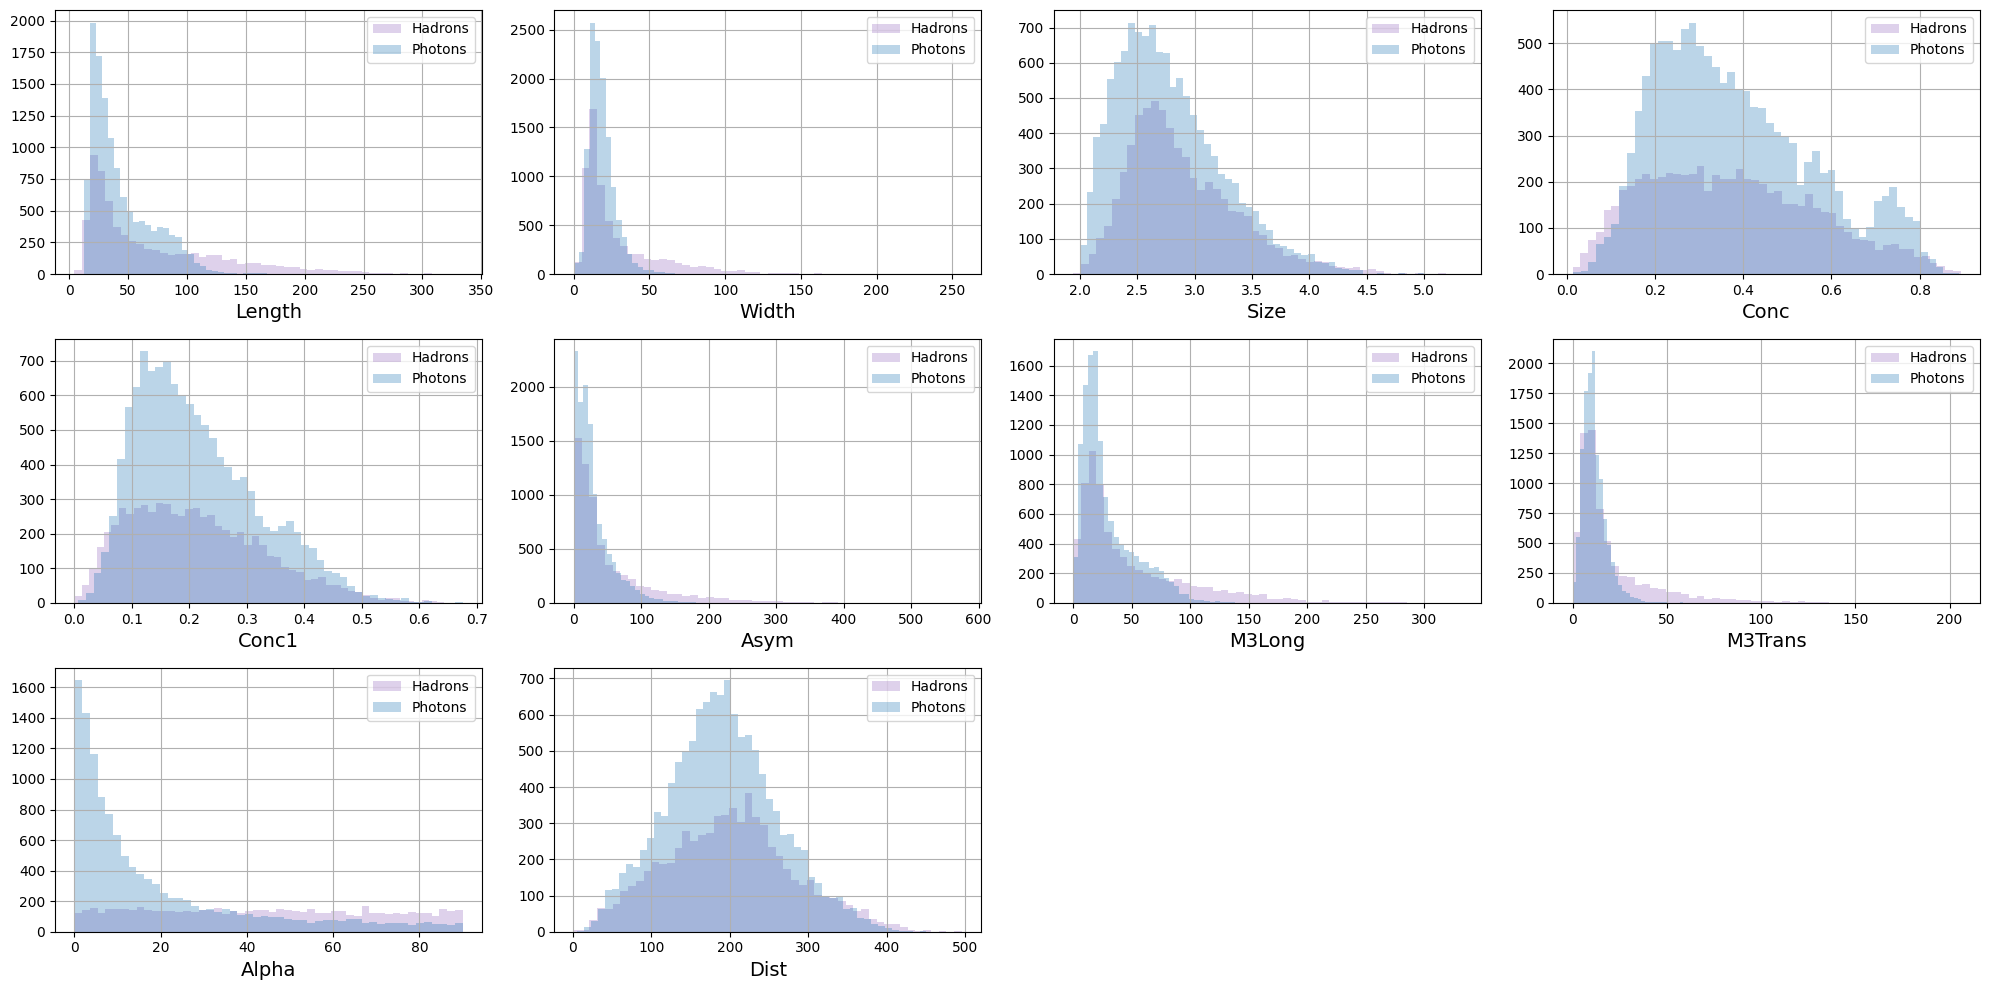

In [ ]:
plot_hists(
    X[y[:, 0] == 0], X[y[:, 0] == 1], names, label1="Hadrons", label2="Photons", bins=50
)

# Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты.

# Обучающая и тестовая выборки

In [ ]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.5, shuffle=True, random_state=11
)

## Задание 1 (0.2 балла)

Проиллюстрируйте распределение y внутри train и test выборки.

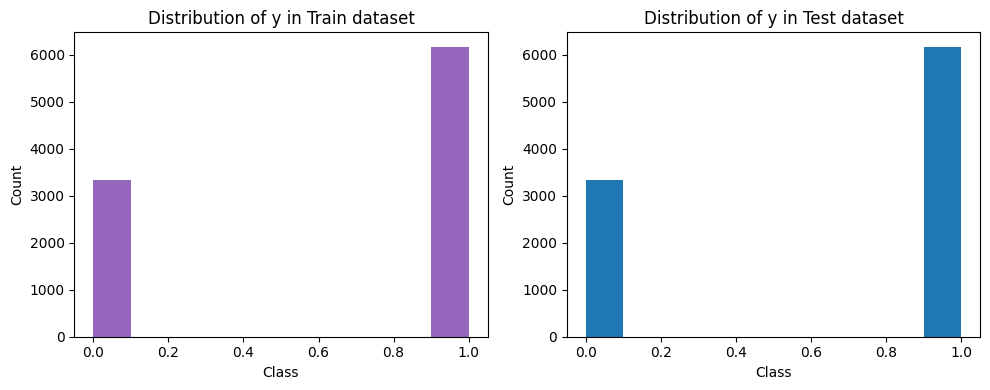

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.hist(y_train, color="C4")
ax1.set_xlabel('Class')
ax1.set_ylabel('Count')
ax1.set_title('Distribution of y in Train dataset')

ax2.hist(y_test, color="C0")
ax2.set_xlabel('Class')
ax2.set_ylabel('Count')
ax2.set_title('Distribution of y in Test dataset')

plt.tight_layout()
plt.show()

## Задание 2 (0.8 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X_train` и `X_test`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по [ссылке](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html). Используйте значение параметра `output_distribution='normal'`.

In [ ]:
### YOUR CODE IS HERE ######
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal', random_state=0)
X_train = qt.fit_transform(X_train)
X_test = qt.transform(X_test)
### THE END OF YOUR CODE ###

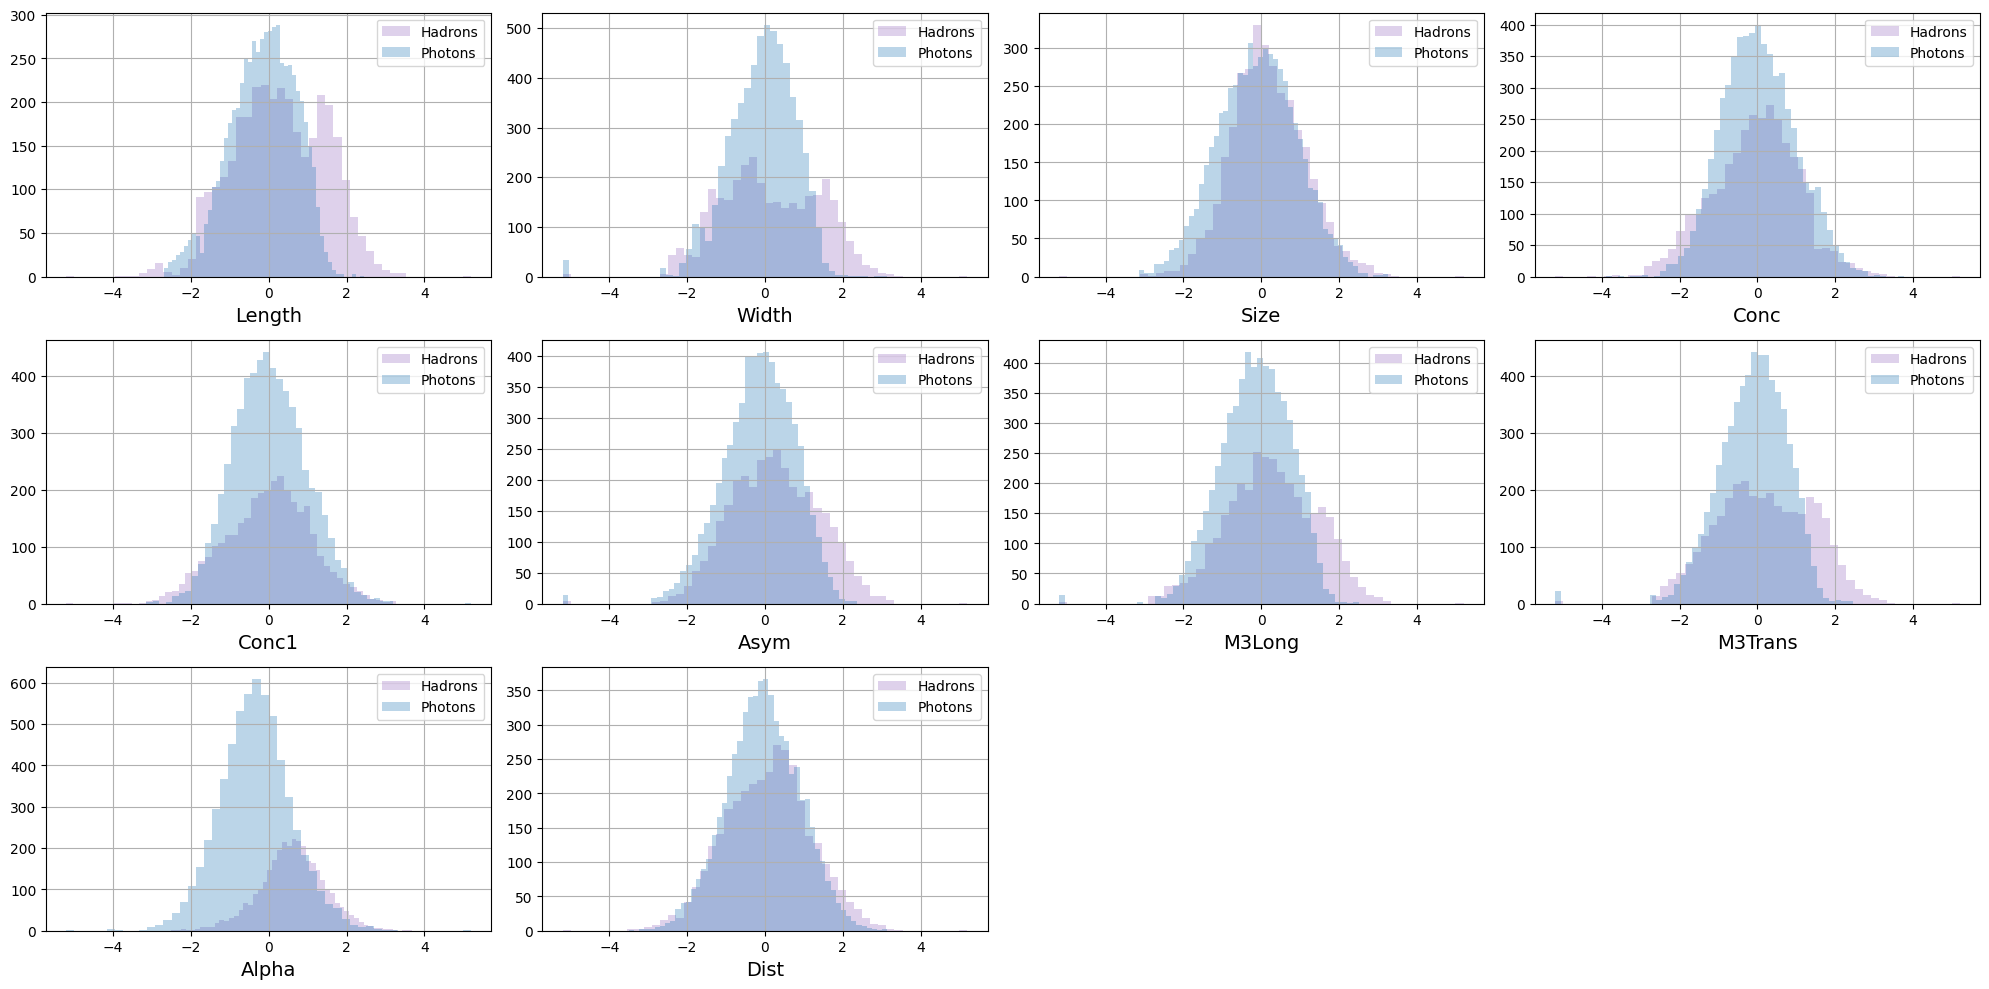

In [ ]:
plot_hists(
    X_train[y_train[:, 0] == 0],
    X_train[y_train[:, 0] == 1],
    names,
    label1="Hadrons",
    label2="Photons",
    bins=50,
)

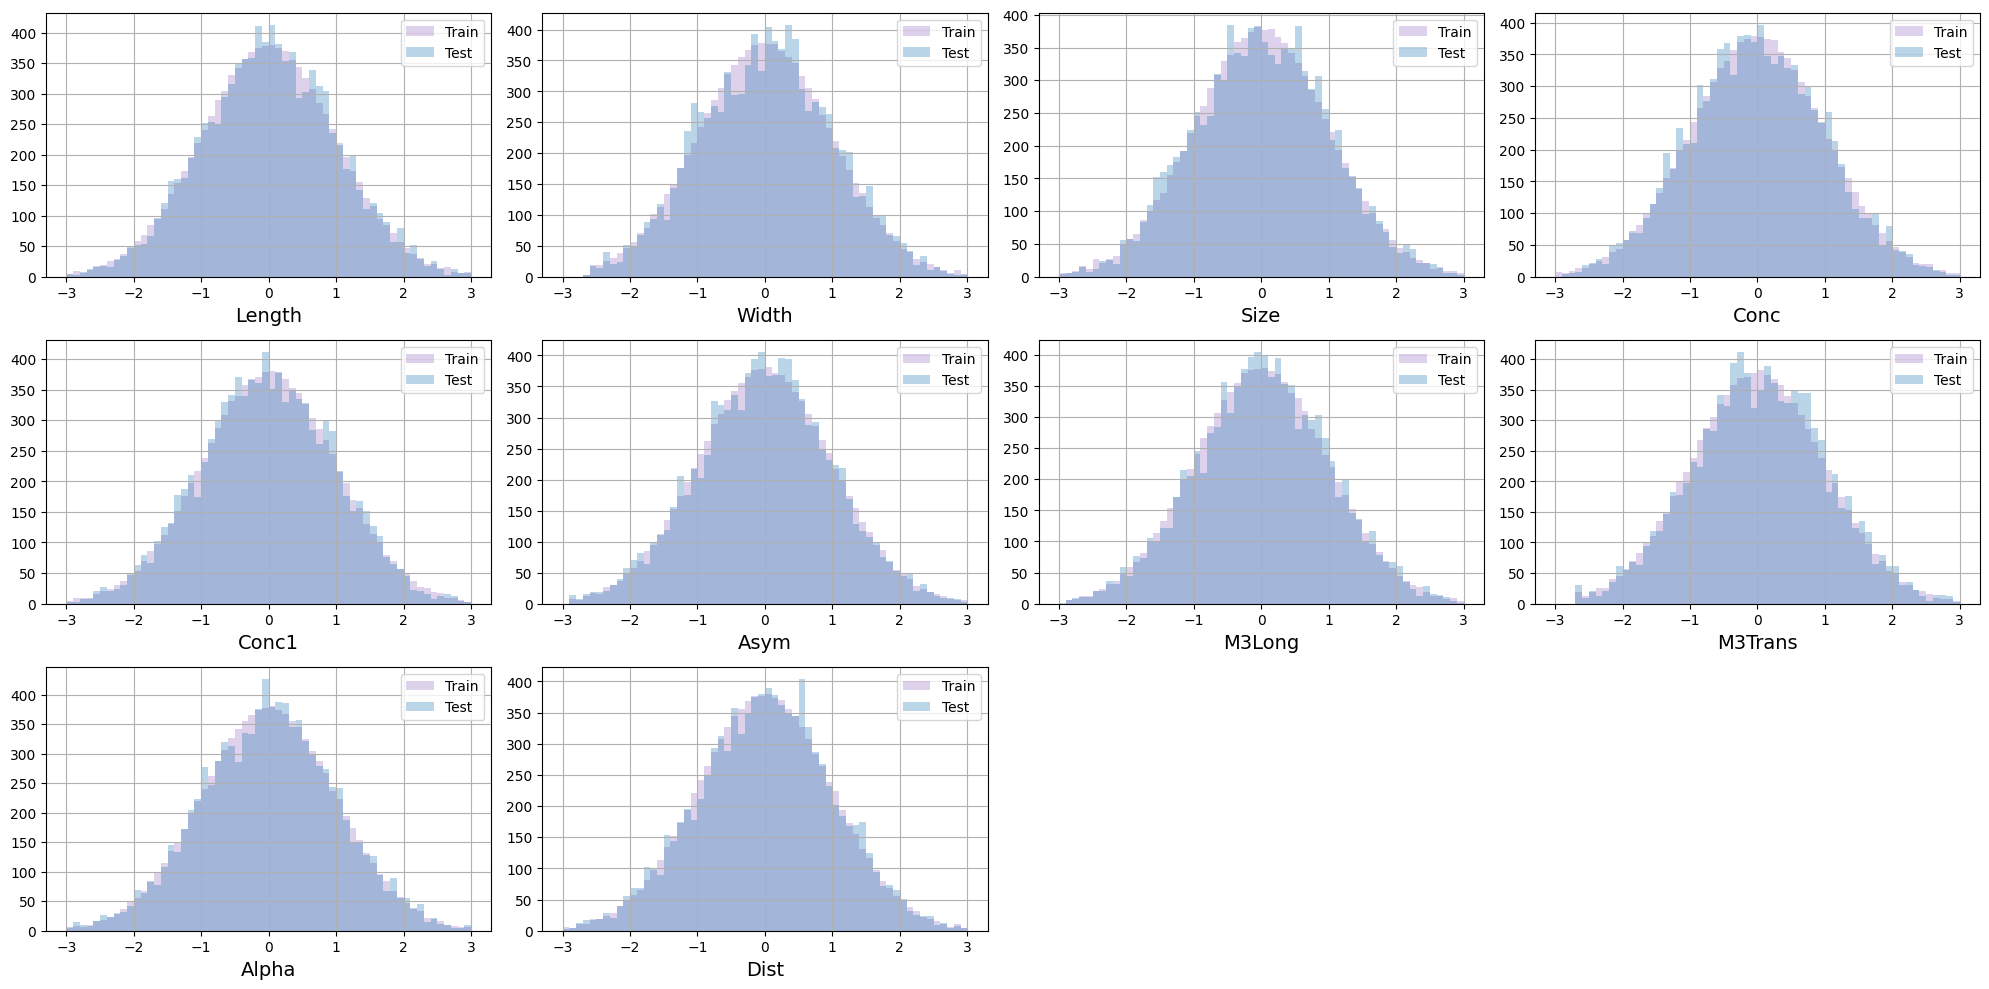

In [ ]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения.

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$.

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
DEVICE

device(type='cuda')

## Задание 3 (0.75 балла)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [ ]:
class Generator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential (
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.BatchNorm1d(100),
            nn.ReLU(),
            nn.Linear(100, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 4 (0.5 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [ ]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)
    X_fake = generator(z, y)
    ### THE END OF YOUR CODE ###
    return X_fake  # numpy

## Задание 5 (0.75 балла)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Какая функция активации должна быть в конце работы модели и почему? А она вообще тут должна быть? Обоснуйте свой выбор.

Берем сигмоиду, потому что на выходе генератора нужно получить распределение вероятностей (сказать, реальный объект или нет)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()

        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
          nn.Linear(n_inputs, 100),
          nn.ReLU(),
          nn.Linear(100, 100),
          nn.ReLU(),
          nn.Linear(100, 1),
          nn.Sigmoid(),
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 6 (0.5 балла)

Реализуйте функцию, которая принимала бы на вход набор сгенерированных и настоящих объектов, разбивала на train и test с учетом баланса классов (real и fake объектов), с соотношением 3 к 1, обучала модель логистической регрессии и градиентного бустинга, которые учились бы отличать настоящие объекты от фальшивых, после чего выводила бы accuracy score на отложенной выборке у обоих моделей.

Ответьте на вопрос: какое значение accuracy score нас бы удовлетворило больше всего? Почему?

accuracy score минимальный удовлетворило бы больше всего.
Мы учимся отличать реальные объекты от сгенерированных, так что чем меньше скор, тем лучше объекты мы сгенерировали.(тем сложнее отличить моделям реальные от фейков -> модели больше ошибаются -> скор меньше)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
def other_agent_score(X_real, y_real, X_fake, y_fake):
    ### YOUR CODE IS HERE ######
    #обучаемся на общих данных
    X = torch.cat([X_real, X_fake], dim=0).detach().cpu().numpy()
    #y = torch.cat([y_real, y_fake], dim=0).detach().cpu().squeeze().numpy()
    y = np.concatenate((np.ones(len(y_real)), np.zeros(len(y_fake))))

    #Параметр stratify позволяет сохранить соотношение классов в исходном наборе данных при разделении.
    X_tr, X_t, y_tr, y_t = train_test_split(
        X, y, stratify=y, test_size=0.25, shuffle=True, random_state=11
        )

    # Обучение логистической регрессии
    log_reg = LogisticRegression()
    log_reg.fit(X_tr, y_tr)
    lr_predictions = log_reg.predict(X_t)
    lin_reg_score = accuracy_score(y_t, lr_predictions)

    # Обучение модели градиентного бустинга
    grad_boost = GradientBoostingClassifier()
    grad_boost.fit(X_tr, y_tr)
    gb_predictions = grad_boost.predict(X_t)
    boosting_score = accuracy_score(y_t, gb_predictions)

    ### THE END OF YOUR CODE ###
    print("Linear regression score: " + str(lin_reg_score))
    print("Boosting score: " + str(boosting_score))
    print()

## Задание 7 (1.5 балла)

Реализуйте класс для обучения генеративной модели.

- Уточнение 1: Нужно ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора. Зачем это делать можно посмотреть в оригинальной статье <https://arxiv.org/pdf/1701.07875.pdf>.
- Подсказка 1: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 2: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [ ]:
from typing_extensions import Literal
from IPython.display import clear_output

class Fitter(object):
    def __init__(
        self,
        generator,
        discriminator,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
        n_critic=5,
        verbose_num_iters=10,
    ):

        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic

        self.opt_gen = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)

        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)

        self.loss_history = []
        iter_i = 0
        count = 0
        gen_steps = 1
        gen_loss_trace = []
        discr_loss_trace = []
        # Fit GAN
        for epoch in range(self.n_epochs):
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######
                real_objects = real_batch.to(DEVICE)
                cond_batch = cond_batch.to(DEVICE)

                # генерируем новые объекты
                z = torch.normal(0, 1, (len(real_batch), self.latent_dim)).to(DEVICE)
                gen_objects = self.generator(z, cond_batch)

                if (iter_i % (gen_steps + self.n_critic)) < gen_steps:
                    # делаем шаг обучения генератора
                    self.opt_gen.zero_grad()
                    gen_loss = -torch.mean(self.discriminator(gen_objects, cond_batch))
                    gen_loss.backward()
                    self.opt_gen.step()
                    gen_loss_trace.append((iter_i, gen_loss.item()))

                    #print ("Generator _______________________________")
                else:
                    # делаем шаг обучения дискриминатора
                    self.opt_disc.zero_grad()
                    discr_loss = -torch.mean(self.discriminator(real_batch, cond_batch)) + torch.mean(self.discriminator(gen_objects, cond_batch))
                    discr_loss.backward()
                    # Ограничение на веса дискриминатора для предотвращения переобучения и улучшения обучения Gan
                    for p in self.discriminator.parameters():
                        p.data.clamp_(-0.01, 0.01)
                    self.opt_disc.step()
                    discr_loss_trace.append((iter_i, discr_loss.item()))
                    #print("Discr")

                iter_i += 1
                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim)).to(DEVICE)
            X_fake = self.generator(Z_noise, y_cond).to(DEVICE)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(
                self.discriminator(X_fake, y_cond)
            )
            self.loss_history.append(loss_epoch.detach().cpu())

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            # n = X_train.shape[0]
            # indices = torch.randperm(n)[:1000]
            # x_tr = torch.tensor(X_train[indices], dtype=torch.float, device=DEVICE)
            # y_cond_tr = y_cond[indices].to(DEVICE)

            # noise = torch.normal(0, 1, (1000, self.latent_dim)).to(DEVICE)
            # x_gen = self.generator(noise, y_cond_tr).to(DEVICE)

            # other_agent_score(x_tr, y_cond_tr, x_gen, y_cond_tr)

            x_tr = X_real[:1000].to(DEVICE)
            x_gen = self.generator(torch.normal(0, 1, (1000, self.latent_dim)).to(DEVICE), y_cond[:1000]).to(DEVICE)
            other_agent_score(x_tr, y_cond[:1000], x_gen, y_cond[:1000])

            ### THE END OF YOUR CODE ###

        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [ ]:
%%time
latent_dim = 10
generator = Generator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1] + y.shape[1])

fitter = Fitter(
    generator,
    discriminator,
    batch_size=50,
    n_epochs=100,
    latent_dim=latent_dim,
    lr=0.0001,
    n_critic=5,
)
fitter.fit(X_train, y_train)

Linear regression score: 0.714
Boosting score: 0.938

Linear regression score: 0.57
Boosting score: 0.922

Linear regression score: 0.552
Boosting score: 0.898

Linear regression score: 0.538
Boosting score: 0.89

Linear regression score: 0.622
Boosting score: 0.892

Linear regression score: 0.566
Boosting score: 0.848

Linear regression score: 0.566
Boosting score: 0.824

Linear regression score: 0.548
Boosting score: 0.83

Linear regression score: 0.636
Boosting score: 0.782

Linear regression score: 0.566
Boosting score: 0.806

Linear regression score: 0.554
Boosting score: 0.748

Linear regression score: 0.548
Boosting score: 0.734

Linear regression score: 0.528
Boosting score: 0.716

Linear regression score: 0.558
Boosting score: 0.74

Linear regression score: 0.546
Boosting score: 0.728

Linear regression score: 0.488
Boosting score: 0.71

Linear regression score: 0.502
Boosting score: 0.718

Linear regression score: 0.532
Boosting score: 0.692

Linear regression score: 0.49
Boo

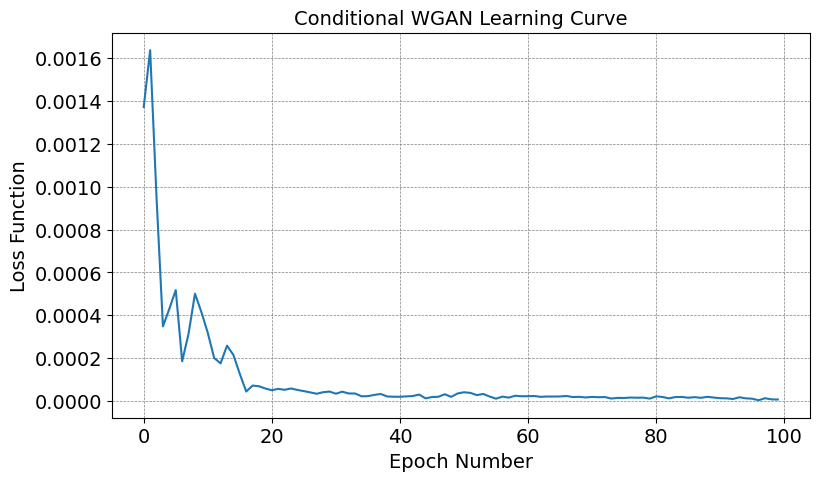

In [ ]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 8 (0.5 балла)

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`. Перед сравнением результатов сделайте обратное квантильное преобразование с помощью трансформера, который вы обучили в задании 2.

In [ ]:
### YOUR CODE IS HERE ######
# X_fake_train =
# X_fake_test =
### THE END OF YOUR CODE ###

-Трейн-

In [ ]:
y_tensor = torch.tensor(y_train, dtype=torch.float, device=DEVICE)
X_fake_train = generate(fitter.generator, y_tensor, latent_dim)

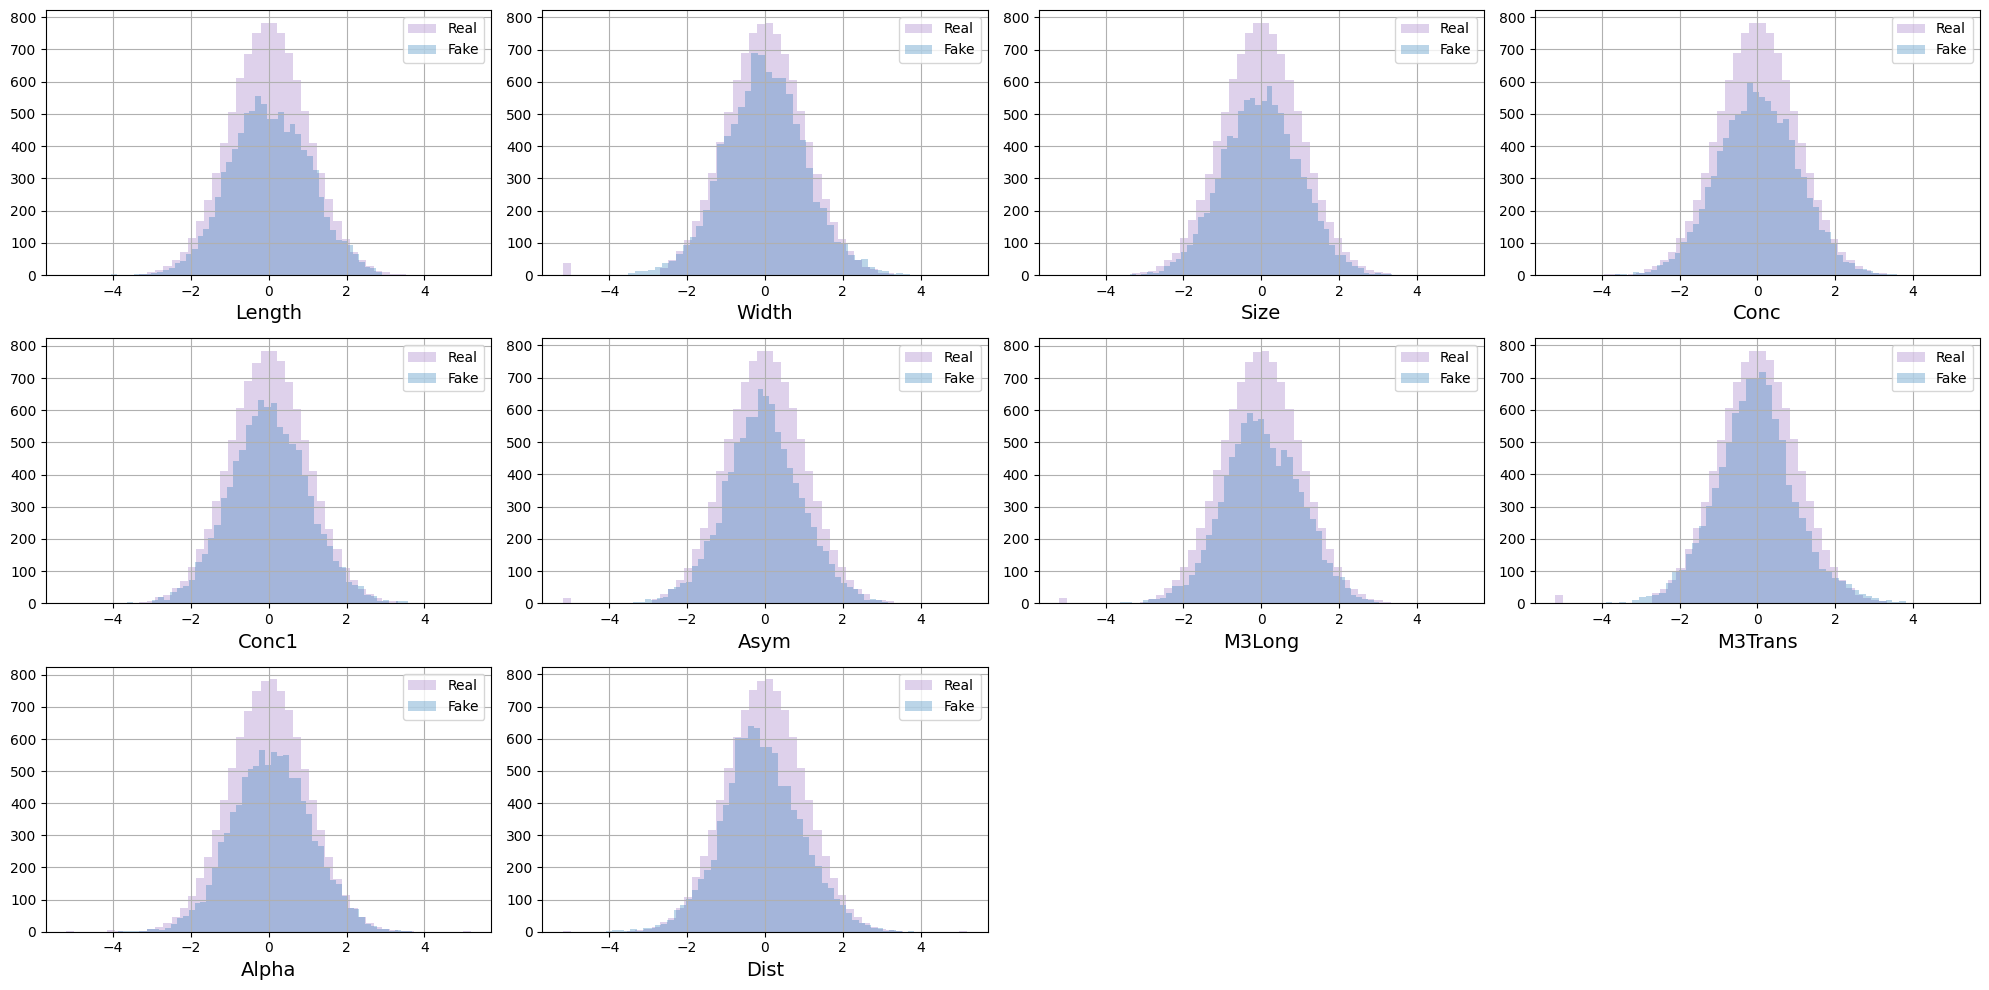

In [ ]:
plot_hists(X_train, X_fake_train.detach().cpu().numpy(), names, label1="Real", label2="Fake", bins=50)

In [ ]:
X_train_inv = qt.inverse_transform(X_train)
X_fake_inv = qt.inverse_transform(X_fake_train.detach().cpu().numpy())

Обратное преобразование трейна

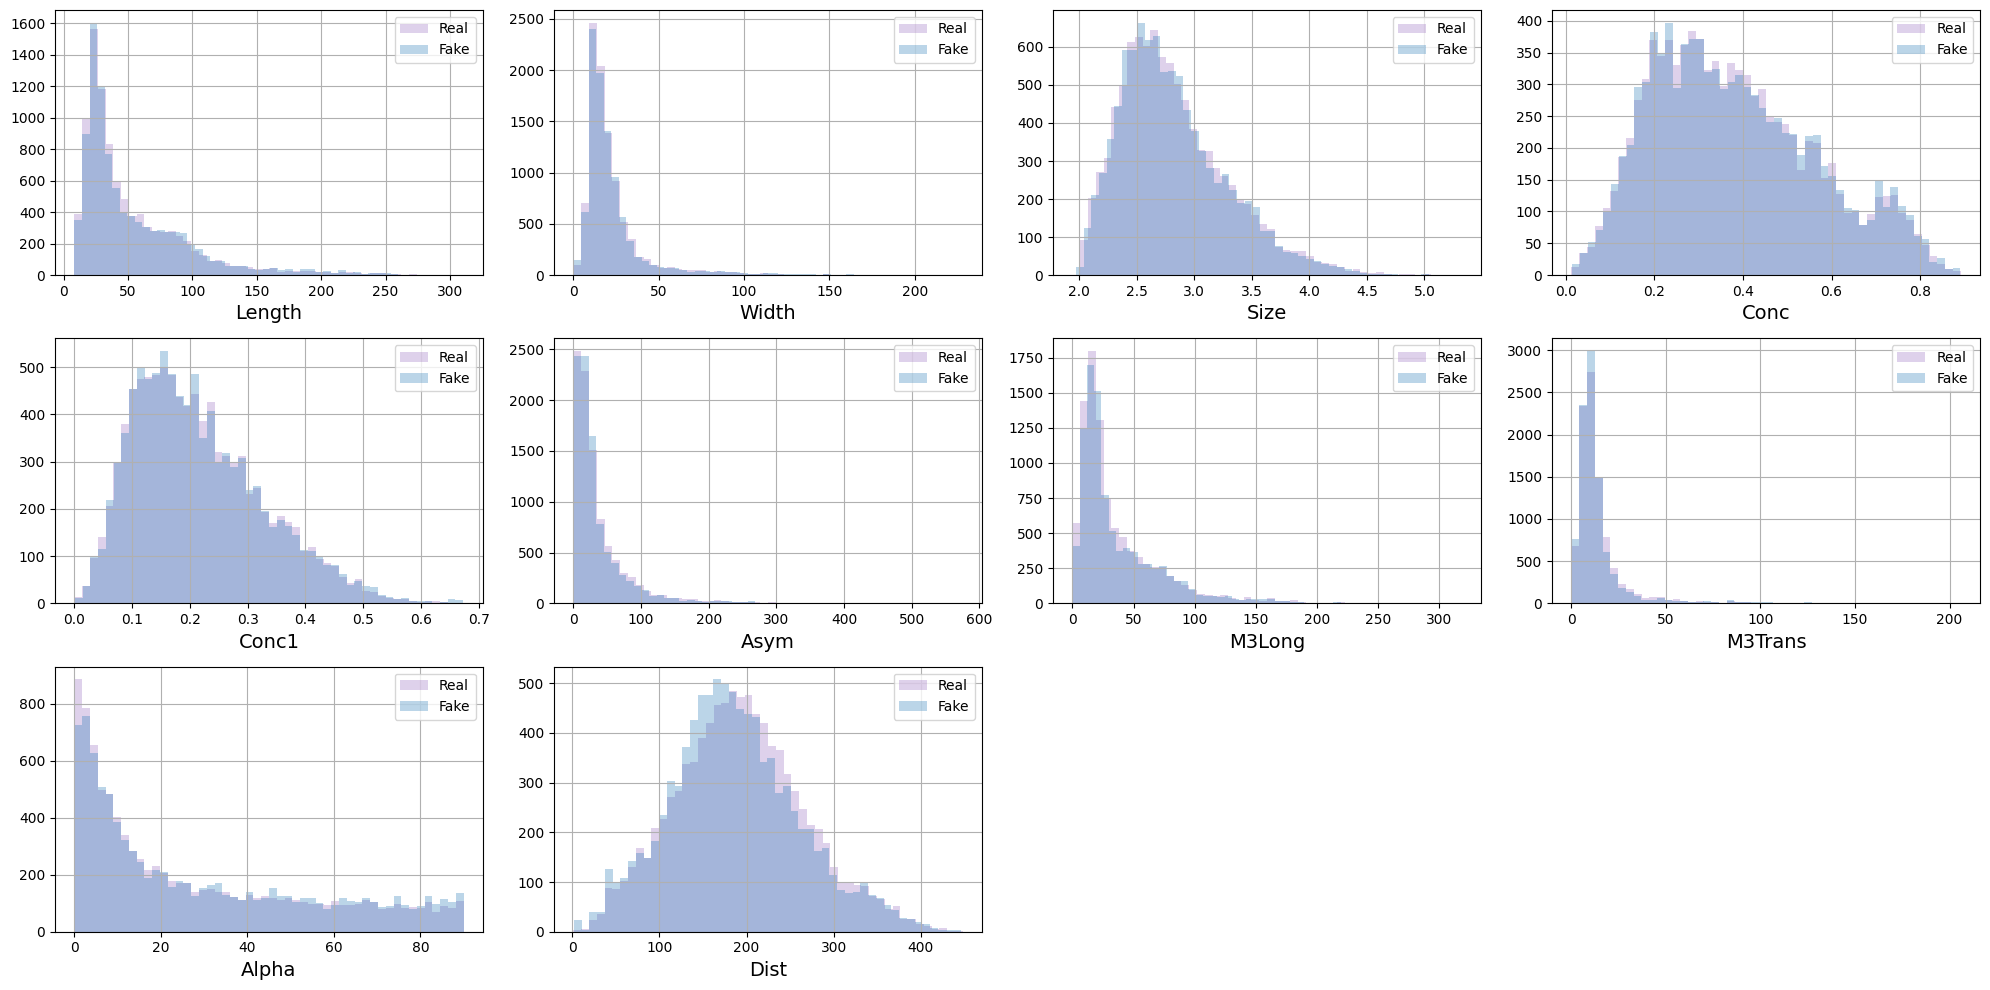

In [ ]:
plot_hists(X_train_inv, X_fake_inv, names, label1="Real", label2="Fake", bins=50)

-Тест-

In [ ]:
y_tensor = torch.tensor(y_test, dtype=torch.float, device=DEVICE)
X_fake_test = generate(fitter.generator, y_tensor, latent_dim)

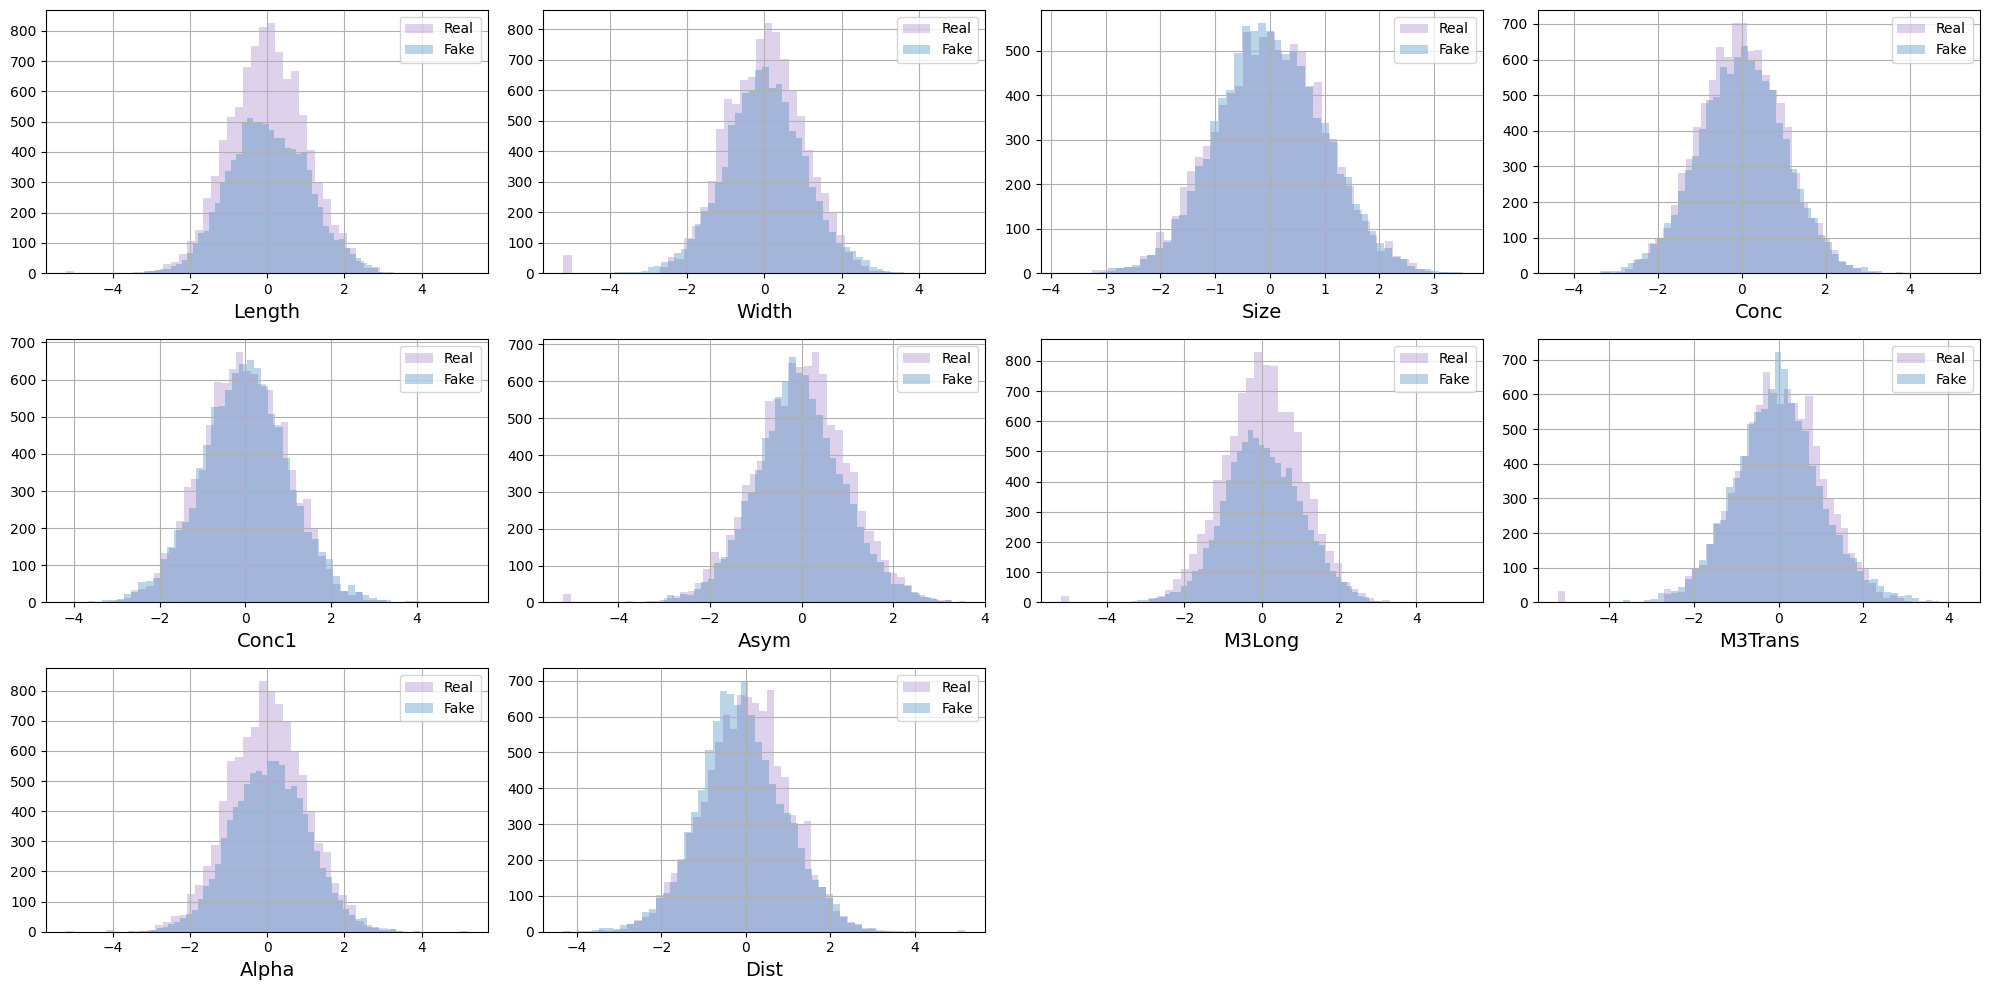

In [ ]:
plot_hists(X_test, X_fake_test.detach().cpu().numpy(), names, label1="Real", label2="Fake", bins=50)

Обратное преобразование теста

In [ ]:
X_train_inv = qt.inverse_transform(X_test)
X_fake_inv = qt.inverse_transform(X_fake_test.detach().cpu().numpy())

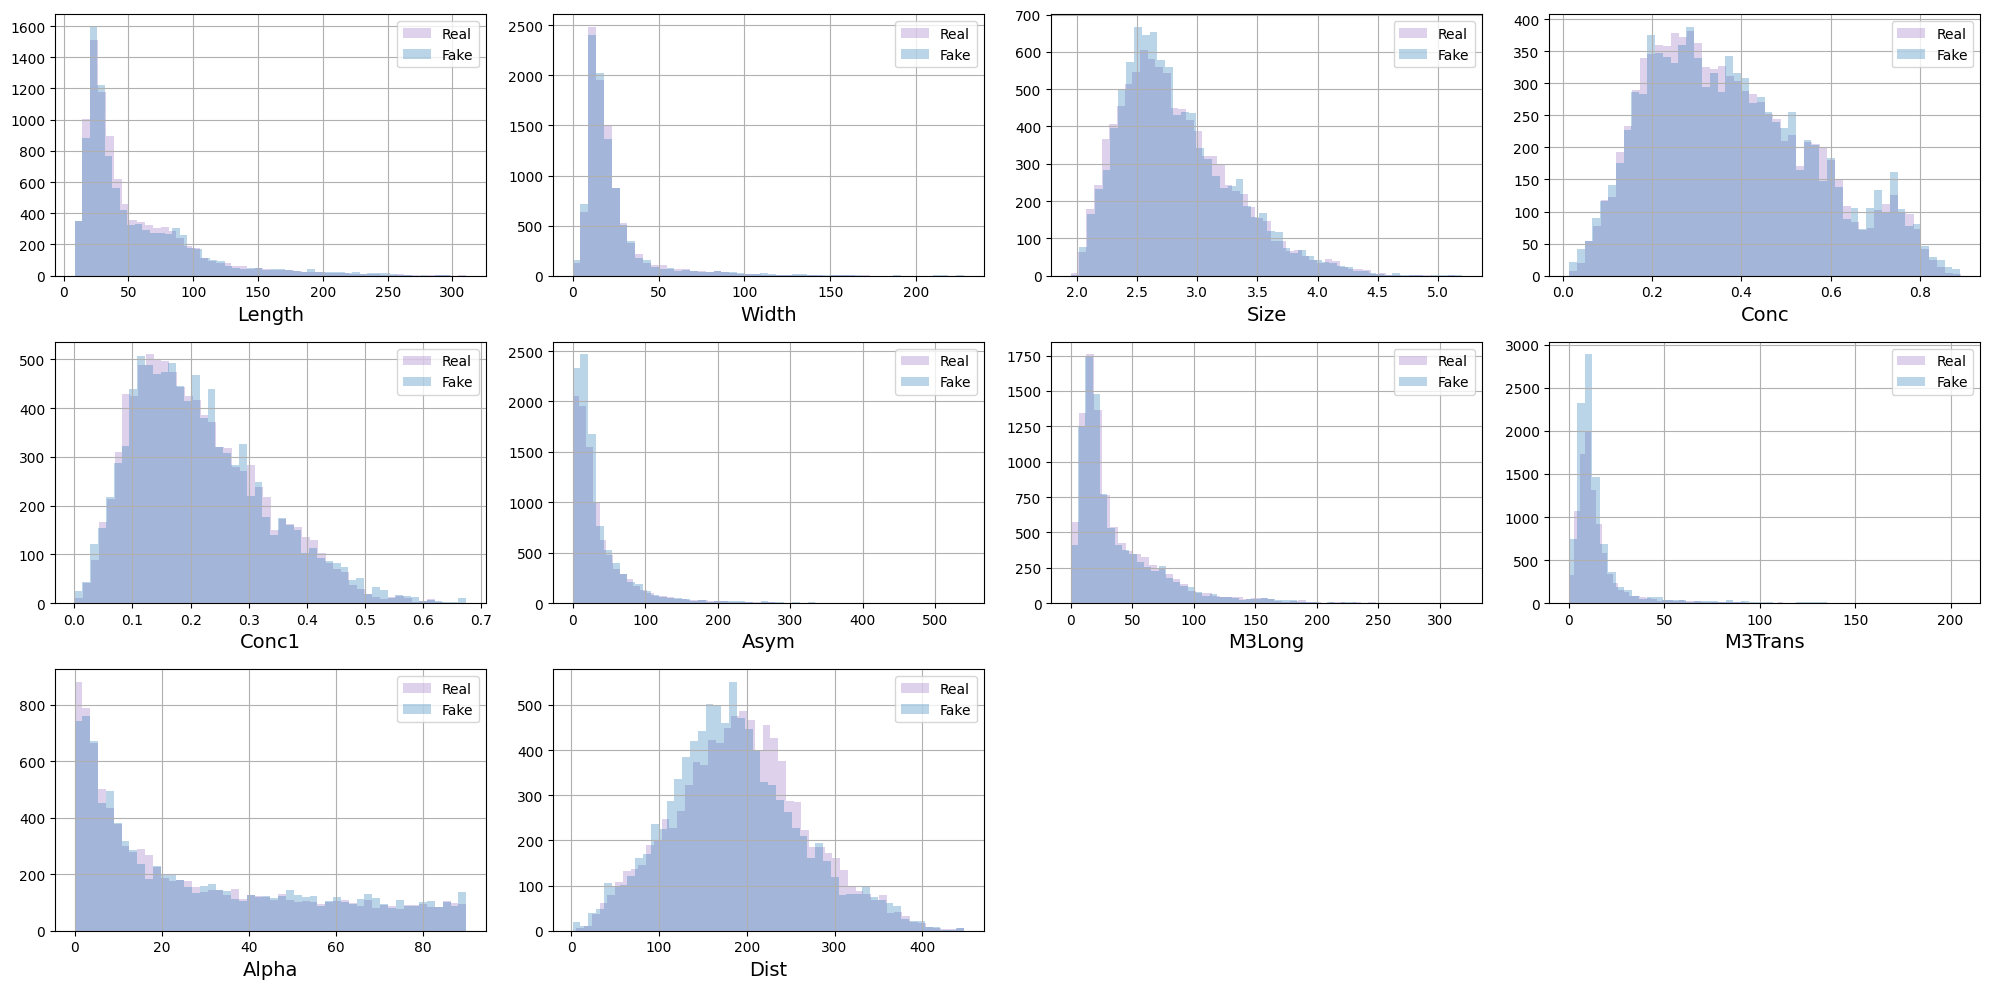

In [ ]:
plot_hists(X_train_inv, X_fake_inv, names, label1="Real", label2="Fake", bins=50)

## Вывод:
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

# Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [ ]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train.detach().cpu().numpy(), X_train), axis=0)
XX_test = np.concatenate((X_fake_test.detach().cpu().numpy(), X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train.detach().cpu().numpy()) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test.detach().cpu().numpy()) + [1] * len(X_test))

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [ ]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6812949676083949


## Задание 9 (0.5 балла)

Опишите ваш эксперимент. Как вы оцениваете полученные результаты? Как вы думаете, какое значение ROC AUC нас удовлетворяет больше всего? Почему?

*Чем ближе Roc Auc  к 0,5 - тем лучше, так как это значит, что мы нагенерировали данные очень похожие на настоящие и классификатор не смог их отличить*

## Диффузионные модели.

Давайте теперь проведем такой же экперимент с простой диффузионной моделью.

## Задание 10 (0.5 балла)

Реализуйте фукнцию из семинара для зашумления данных, адаптировав ее под наш тип данных.

In [ ]:
def corrupt(x, amount):
    ### YOUR CODE IS HERE ######
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1)#двумерная таблица
    x = x * (1 - amount) + noise * amount
    ### THE END OF YOUR CODE ###
    return x

## Добавим sсheduler, он пригодится вам при обучении модели

In [ ]:
!pip install diffusers -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 14.5 MB/s eta 0:00:00


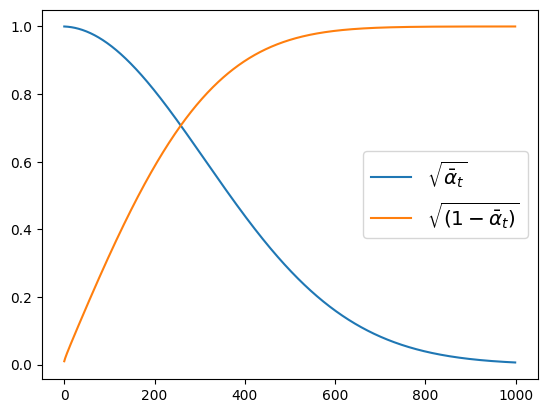

In [ ]:
from diffusers import DDPMScheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, clip_sample = False)
plt.plot(
    noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$"
)
plt.plot(
    (1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5,
    label=r"$\sqrt{(1 - \bar{\alpha}_t)}$",
)
plt.legend(fontsize="x-large")

## Задание 11 (0.5 балла)

Реализуйте нейронную сеть. В качетсве архитектуры можете взять модель генератора. В процессе экспериментов попробуйте изменять архитектуру модели для улучшения качества сгенерированных объектов (Кстати, как вы будете качество измерять?).

- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

In [153]:
class DiffusionGenerator(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(DiffusionGenerator, self).__init__()

        ### YOUR CODE IS HERE ######
        # self.net = nn.Sequential (
        #     nn.Linear(n_inputs, 100),
        #     nn.BatchNorm1d(100),
        #     nn.ReLU(),
        #     nn.Linear(100,100),
        #     nn.BatchNorm1d(100),
        #     nn.ReLU(),
        #     nn.Linear(100, n_outputs)
        # )

        self.net = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Linear(64, n_outputs)
        )

        ### THE END OF YOUR CODE ###

    def forward(self, z, y, scheduler=None):
        zy = torch.cat((z, y), dim=1)
        if scheduler is not None:
            zy_noisy = scheduler.add_noise(zy)
        else:
            zy_noisy = zy
        return self.net(zy_noisy)

## Задание 12 (0.5 балла)

Напишите функцию для генерации нового объекта с помощью обученной модели.

In [154]:
def generate_with_diffusion(model, y, latent_dim, sheduler):
    ### YOUR CODE IS HERE ######
    z = torch.normal(0, 1, (y.shape[0], latent_dim)).to(DEVICE)#noise

    n_steps = 64
    for i in range(n_steps):
      with torch.no_grad():
          pred = model(z, y)
      mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
      z = z * (1 - mix_factor) + pred * mix_factor  # Move part of the way there
    ### THE END OF YOUR CODE ###
    return z

## Задание 13 (2 балла)

Напишите класс обучения диффузионной модели и обучите модель, после чего опишите полученные результаты. В качестве подсказки - опирайтесь на семинар по диффузионным моделям. Вы можете изменять некоторые части кода для вашего удобства, но оставляйте в таком случаи комментарии, пожалуйста.

In [155]:
#Удалила n_critics, тк мы работаем с 1 моделью
class DiffusionFitter(object):
    def __init__(
        self,
        model,
        batch_size=32,
        n_epochs=10,
        latent_dim=1,
        lr=0.0001,
    ):

        self.model = model
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr

        self.opt_gen = torch.optim.RMSprop(self.model.parameters(), lr=self.lr)

        self.model.to(DEVICE)

    def fit(self, X, y):

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)

        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)

        # Turn on training
        self.model.train(True)

        self.loss_history = []
        loss_fn = nn.MSELoss()

        # Fit GAN
        for epoch in range(self.n_epochs):
            loss_epoch = 0
            for i, (real_batch, cond_batch) in enumerate(
                DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)
            ):

                ### YOUR CODE IS HERE ######

                real_batch = real_batch.to(DEVICE)
                noise_amount = torch.rand(real_batch.shape[0]).to(DEVICE)
                noisy_x = corrupt(real_batch, noise_amount)

                pred = self.model(noisy_x, cond_batch)

                loss = loss_fn(pred, real_batch)
                self.opt_gen.zero_grad()
                loss.backward()
                self.opt_gen.step()

                loss_epoch += loss.item()

                ### THE END OF YOUR CODE ###

            # caiculate and store loss after an epoch

            self.loss_history.append(loss_epoch)

            # Создайте выборку из 1000 объектов из X_train и 1000 сгенерированных объектов
            # И запустите работу фукнции other_agent_score

            ### YOUR CODE IS HERE ######
            x_tr = X_real[:1000].to(DEVICE)
            #(z, y, [scheduler])
            x_gen = self.model(torch.normal(0, 1, (1000, self.latent_dim)).to(DEVICE), y_cond[:1000]).to(DEVICE)
            other_agent_score(x_tr, y_cond[:1000], x_gen, y_cond[:1000])
            ### THE END OF YOUR CODE ###

        # Turn off training
        self.model.train(False)

In [156]:
%%time
latent_dim = 10
model = DiffusionGenerator(n_inputs=latent_dim + y.shape[1], n_outputs=X_train.shape[1])

diffusionFitter = DiffusionFitter(
    model,
    batch_size=50,
    n_epochs=200,
    latent_dim=latent_dim,
    lr=0.0001,
)
diffusionFitter.fit(X_train, y_train)

Linear regression score: 0.532
Boosting score: 0.748

Linear regression score: 0.5
Boosting score: 0.7

Linear regression score: 0.488
Boosting score: 0.646

Linear regression score: 0.512
Boosting score: 0.644

Linear regression score: 0.458
Boosting score: 0.646

Linear regression score: 0.504
Boosting score: 0.67

Linear regression score: 0.474
Boosting score: 0.616

Linear regression score: 0.492
Boosting score: 0.612

Linear regression score: 0.496
Boosting score: 0.614

Linear regression score: 0.474
Boosting score: 0.646

Linear regression score: 0.464
Boosting score: 0.64

Linear regression score: 0.506
Boosting score: 0.62

Linear regression score: 0.492
Boosting score: 0.586

Linear regression score: 0.496
Boosting score: 0.616

Linear regression score: 0.512
Boosting score: 0.64

Linear regression score: 0.488
Boosting score: 0.658

Linear regression score: 0.5
Boosting score: 0.634

Linear regression score: 0.514
Boosting score: 0.628

Linear regression score: 0.462
Boostin

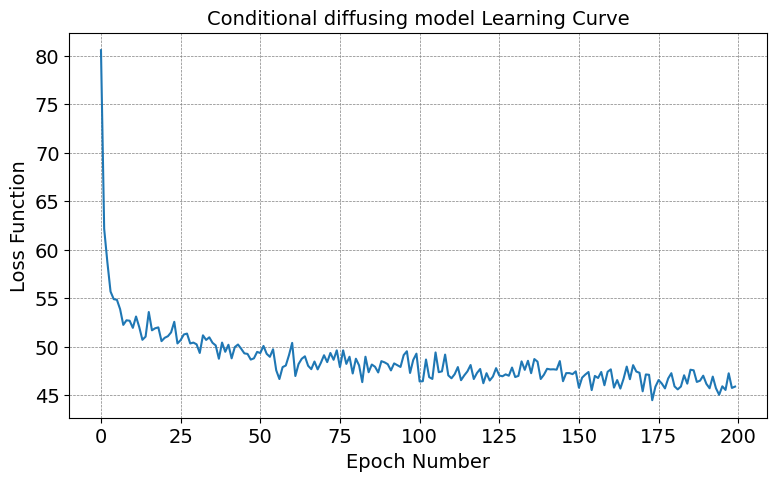

In [157]:
# diffusion learning curve
plt.figure(figsize=(9, 5))
plt.plot(diffusionFitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional diffusing model Learning Curve", size=14)
plt.grid(linestyle="--", linewidth=0.5, color="0.5")
plt.show()

## Задание 14 (0.5 балла)
По аналогии с прошлым экспериментом с GAN моделью сгенерируйте выборку фейковых объектов равную размеру тестовой выборки и обучите градиентный бустинг. Обучите модель отличать реальные объекты от фейковых, после чего расчитайте метрики ROC-AUC и accuracy score. Какие получились результаты? Как вы их оцениваете? А в сравнении с GAN моделью?

In [160]:
y_tensor = torch.tensor(y_train, dtype=torch.float, device=DEVICE)
X_fake_train = generate_with_diffusion(model, y_tensor, latent_dim, noise_scheduler)

In [161]:
X_train_inv = qt.inverse_transform(X_train)
X_fake_inv = qt.inverse_transform(X_fake_train.detach().cpu().numpy())

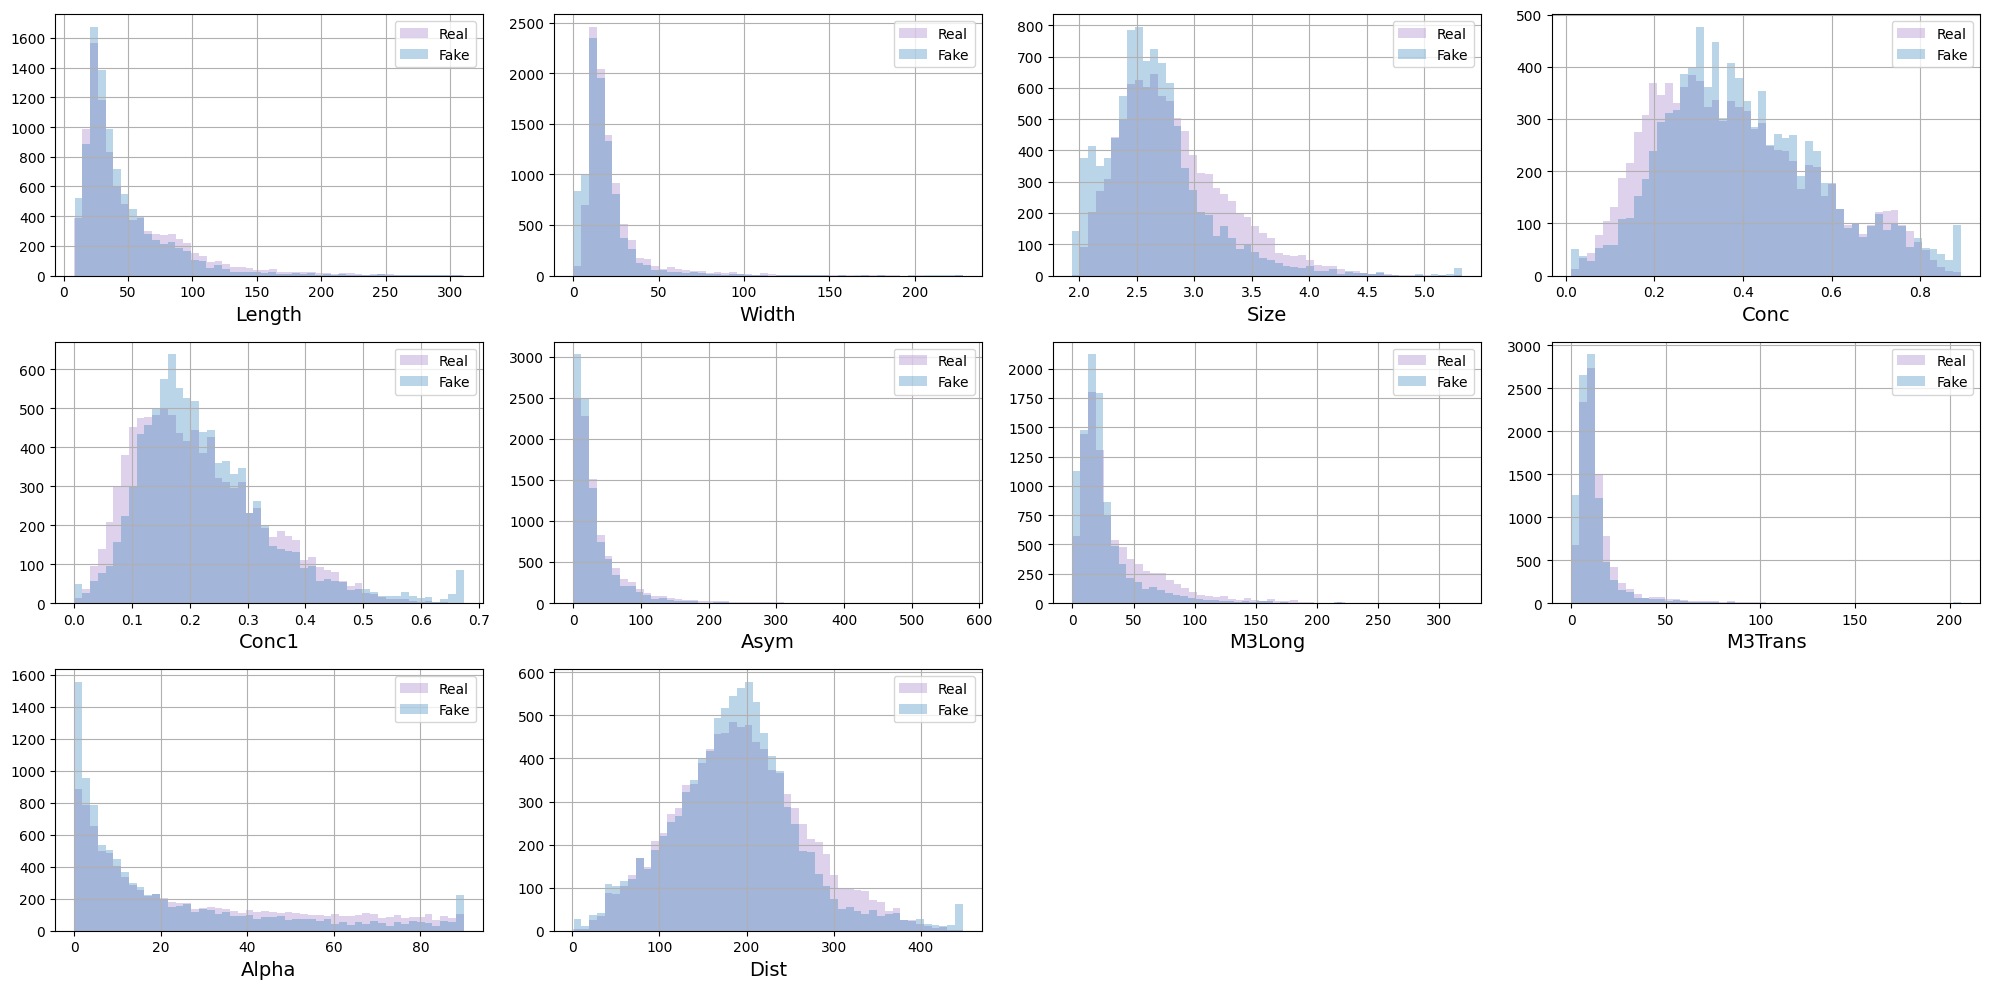

In [ ]:
plot_hists(X_train_inv, X_fake_inv, names, label1="Real", label2="Fake", bins=50)

In [162]:
y_tensor = torch.tensor(y_test, dtype=torch.float, device=DEVICE)
X_fake_test = generate_with_diffusion(model, y_tensor, latent_dim, noise_scheduler)

In [163]:
X_test_inv = qt.inverse_transform(X_test)
X_fake_inv = qt.inverse_transform(X_fake_test.detach().cpu().numpy())

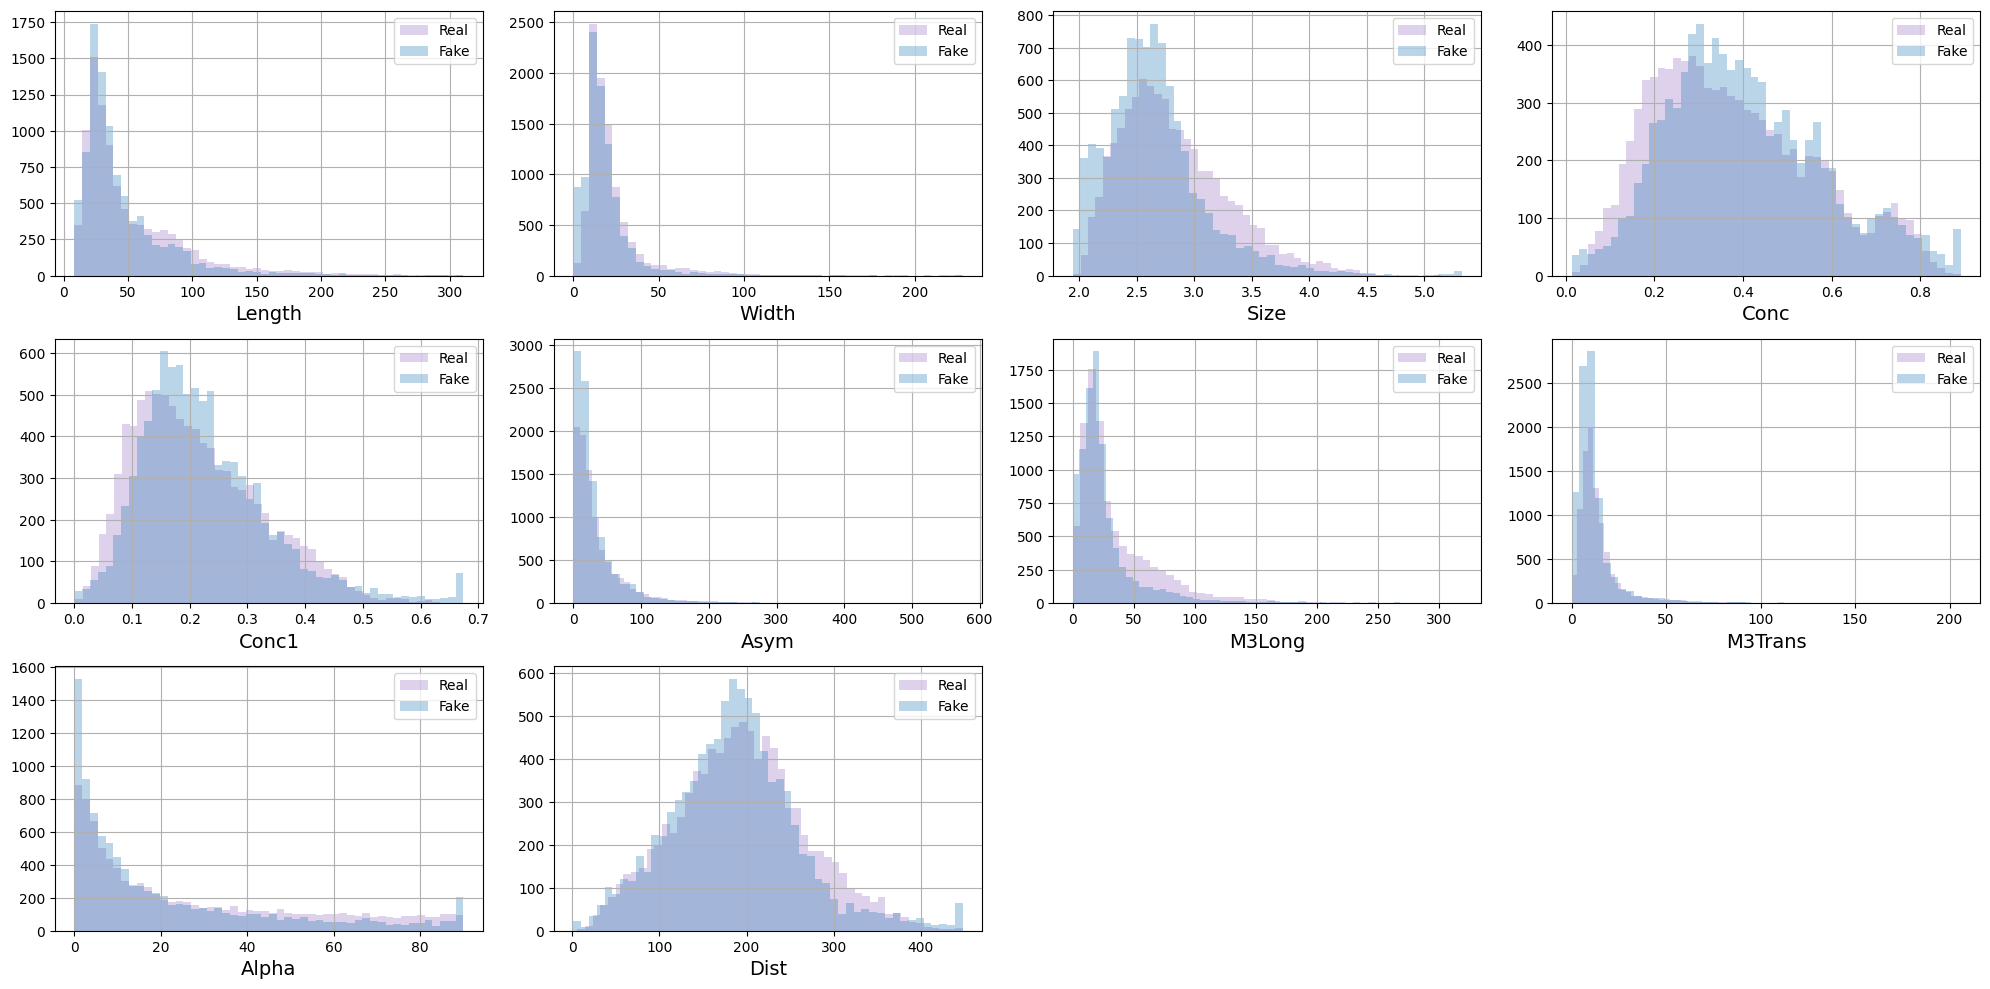

In [ ]:
plot_hists(X_test_inv, X_fake_inv, names, label1="Real", label2="Fake", bins=50)

In [164]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train.detach().cpu().numpy(), X_train), axis=0)
XX_test = np.concatenate((X_fake_test.detach().cpu().numpy(), X_test), axis=0)

yy_train = np.array([0] * len(X_fake_train.detach().cpu().numpy()) + [1] * len(X_train))
yy_test = np.array([0] * len(X_fake_test.detach().cpu().numpy()) + [1] * len(X_test))

In [165]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [166]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.8491687260407718


Вывод:
У диффузионки качество получилось хуже, возможно, нужно подольше обучить, модель посложнее взять, или пробовать шум предсказывать, но я не поняла, как потом из изображения его удалять, поэтому сделала сразу предсказание картинки.

## Отзыв

Поздравляю! Вы дошли до конца. Оставьте ваш отзыв ячейкой ниже или отправьте его в канал курса, нам будет очень интересно!